## Objective - To build a model for predicting whether a customer is happy or not

Importing relevant libraries

In [1]:
import os
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance        # Feature importance
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import random
from lazypredict.Supervised import LazyClassifier
from sklearn import datasets
from sklearn.utils.testing import ignore_warnings
from xgboost.sklearn import XGBRegressor

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


Change directory and import the data set

In [2]:
os.chdir("F:\Blue Sky\EVERYTHING\DATA SCIENCE\Apziva\Happy Customers")
hc = pd.read_csv("ACME-HappinessSurvey2020.csv")
hc.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


Renaming columns for increasing readability

In [3]:
hc.columns = ['happiness_status', 'timely_delivery', 'exp_contents', 'ordered_all', 'good_price', 'courier_satisf', 'easy_app_order']
hc.head()

,happiness_status,timely_delivery,exp_contents,ordered_all,good_price,courier_satisf,easy_app_order
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


### Exploratory Data Analysis

In [4]:
hc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   happiness_status  126 non-null    int64
 1   timely_delivery   126 non-null    int64
 2   exp_contents      126 non-null    int64
 3   ordered_all       126 non-null    int64
 4   good_price        126 non-null    int64
 5   courier_satisf    126 non-null    int64
 6   easy_app_order    126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [5]:
hc.describe()

,happiness_status,timely_delivery,exp_contents,ordered_all,good_price,courier_satisf,easy_app_order
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,4.33,2.53,3.31,3.75,3.65,4.25
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,4.00,2.00,3.00,3.00,3.00,4.00
50%,1.00,5.00,3.00,3.00,4.00,4.00,4.00
75%,1.00,5.00,3.00,4.00,4.00,4.00,5.00
max,1.00,5.00,5.00,5.00,5.00,5.00,5.00


No null or missing values. No imputation required

Check class balancing to identify if oversampling or undersampling is required

In [6]:
hc['happiness_status'].value_counts()

1    69
0    57
Name: happiness_status, dtype: int64

The class of the independent variable is balanced as 53% of the values belong to one class and 47% to another class. Oversampling or undersampling is not required

Set seed for reproducability

In [7]:
seed_value = 42
random.seed(seed_value)

Train Test split - For training and testing data

In [8]:
X = hc.drop(columns = 'happiness_status')
y = hc['happiness_status']
print(X.head())
print(y.head())

   timely_delivery  exp_contents  ordered_all  good_price  courier_satisf  \
0                3             3            3           4               2   
1                3             2            3           5               4   
2                5             3            3           3               3   
3                5             4            3           3               3   
4                5             4            3           3               3   

   easy_app_order  
0               4  
1               3  
2               5  
3               5  
4               5  
0    0
1    0
2    1
3    0
4    0
Name: happiness_status, dtype: int64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
print(X_train.head())
print(X_train.shape)
print(X_test.shape)

     timely_delivery  exp_contents  ordered_all  good_price  courier_satisf  \
116                3             4            4           5               1   
13                 4             2            4           5               4   
33                 3             2            4           4               4   
75                 3             2            3           3               4   
26                 3             3            3           5               5   

     easy_app_order  
116               3  
13                3  
33                5  
75                4  
26                5  
(100, 6)
(26, 6)


## Modeling

Creating different classification models to train them on training data and testing accuracy. We'll start with basic models like Logistic Regression and then move on to complex models like Random Forest.The idea is to get best possible F1-score accuracy and hence identify best model.

## 1. Logistic Regression

1a. Creating Logistic Regression model using Statsmodels module to identify statistical significance of features 

In [10]:
X_sm = X                          # Creating a copy of X because we'll be adding a constant for Statsmodels logistic regression
X_sm = sm.add_constant(X_sm)      # Adding constant y-intercept for training data
logit_model = sm.Logit(y,X_sm)    # Building the model (An instance og Logistic Regression)
result = logit_model.fit()        # Fitting the data
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.637875
         Iterations 5
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.074   
Dependent Variable: happiness_status AIC:              174.7445
Date:               2021-06-19 01:05 BIC:              194.5985
No. Observations:   126              Log-Likelihood:   -80.372 
Df Model:           6                LL-Null:          -86.764 
Df Residuals:       119              LLR p-value:      0.046597
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
const           -3.5674   1.4891 -2.3957 0.0166 -6.4859 -0.6489
timely_delivery  0.5738   0.2888  1.9866 0.0470  0.0077  1.1400
exp_contents    -0.0937   0

timely_delivery is the most statistically significant variable and good_price is least statistically significant variable

1b. Creating Logistic Regression model using sklearn module to calculate F1-score

In [11]:
logreg = LogisticRegression()    # Building model as an instance of Logistic Regression
logreg.fit(X_train, y_train)     # Fitting training data
y_pred_logit = logreg.predict(X_test)  # Predict based on test data

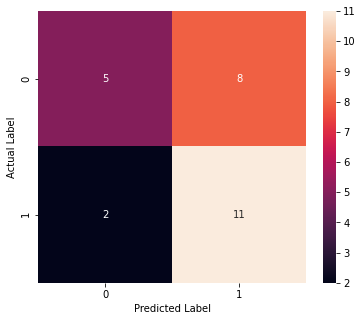

In [12]:
confusion_matrix = confusion_matrix(y_test, y_pred_logit)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (6,5))
sn.heatmap(df_cm, annot = True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.58      0.85      0.69        13

    accuracy                           0.62        26
   macro avg       0.65      0.62      0.59        26
weighted avg       0.65      0.62      0.59        26



F1-score accuracy with Logistic Regression is 62%

# 2. K Nearest Neighbors

K Nearest Neighbors is another popular classification alogorithm. It looks at "K" neighbors and classifies the test data point based on majority.

In [14]:
k_range = range(1,100)                               # Range of k for experimentation
scores = {}                                          # Empty dictionary for storing scores for each value of k
score_list = []                                      # Empty list for storing scores
for k in k_range:                                    # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)      # Build an instance of KNeighborsClassifier Model
    knn.fit(X_train, y_train)                        # Fit the model with training data
    y_pred_knn = knn.predict(X_test)                 # Make predictions for test data
    scores[k] = f1_score(y_test, y_pred_knn)         # Generate F1 score and append to scores dictionary with respective k value
    score_list.append(f1_score(y_test, y_pred_knn))  # Append F1 score to score_list dictionary

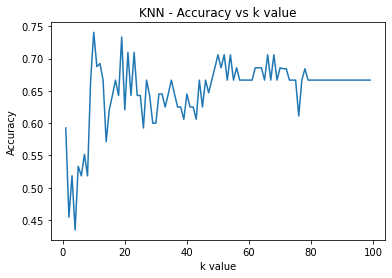

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [16]:
# Get maximum score
max(score_list)

0.7407407407407408

In [17]:
# Get K value for maximum score
max(scores, key=scores.get)

10

Maximum F1 score accuracy occurs at K=10

### Final KNN model

In [18]:
knn_f = KNeighborsClassifier(n_neighbors = 10)     # Build an instance of KNeighborsClassifier Model with k=10
knn_f.fit(X_train, y_train)                        # Fit the model with training data
y_pred_knn_f = knn_f.predict(X_test)               # Make predictions for test data

In [19]:
print(classification_report(y_test, y_pred_knn_f))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.71      0.77      0.74        13

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



Maximum F1 score accuracy with K Nearest Neighbors is 73% and it occurs at K=10

# 3. Decision Tree

Decison tree is another classification model which classifies data into categories based on certain tests

In [20]:
dtc = DecisionTreeClassifier(random_state = 0)      # Create an instance of DecisionTreeClassifier
dtc.fit(X_train, y_train)                           # Fit the model with training data
y_pred_dtc = dtc.predict(X_test)                    # Make predictions for test data

In [21]:
y_pred_dtc                                          # Checking predictions

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1], dtype=int64)

In [22]:
print(classification_report(y_test, y_pred_dtc))    # Get classification report

              precision    recall  f1-score   support

           0       0.50      0.54      0.52        13
           1       0.50      0.46      0.48        13

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.50        26
weighted avg       0.50      0.50      0.50        26



F1 score accuracy with Decision Tree Model is 50%

Cross Validation - For understanding accuracy when data is split differently for training and testing

In [23]:
cross_val_score(dtc, X_train, y_train, cv = 10)

array([0.7, 0.7, 0.5, 0.6, 0.8, 0.5, 0.6, 0.6, 0.8, 0.4])

There's a big variation in the accuracy (from 0.4 to 0.8) which suggests that data is not homogeneous possibly due to low number of data points

# 4. Random Forest

Random forest is a popular ensemble model. It is an ensemble of multiple decision trees.

In [24]:
rf = RandomForestClassifier(random_state = 0)    # Create an instance of RandomForestClassifier
rf.fit(X_train, y_train)                         # Fit the model with training and test data
y_pred_rf = rf.predict(X_test)                   # Make predictions on the test data

In [25]:
print(classification_report(y_test, y_pred_rf))  # Generate classification report

              precision    recall  f1-score   support

           0       0.56      0.38      0.45        13
           1       0.53      0.69      0.60        13

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.53        26
weighted avg       0.54      0.54      0.53        26



The F1 score accuracy for Random Forest improved slightly to 54% compared to 50% for Decision Tree model

Random forest is a popular model which generally gives good results. We can poentially improve our results using hyperparameter tuning. Let's try that out.

#### Hyperparameter tuning

In [26]:
# Create a grid of hyperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [27]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [28]:
rf_random.best_params_                               # Get best parameters

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

Create a new Random Forest model with best parameters

In [29]:
# Create an instance of RandomForestClassifier with best parameters
rf_best_params = RandomForestClassifier(n_estimators = 1400, min_samples_split = 2, min_samples_leaf = 1, 
                                        max_features = 'auto',max_depth = 100, bootstrap =True, random_state = 0)    
rf_best_params.fit(X_train, y_train)                         # Fit the model with training and test data

RandomForestClassifier(max_depth=100, n_estimators=1400, random_state=0)

In [30]:
print(classification_report(y_test, rf_best_params.predict(X_test)))  # Generate classification report

              precision    recall  f1-score   support

           0       0.60      0.46      0.52        13
           1       0.56      0.69      0.62        13

    accuracy                           0.58        26
   macro avg       0.58      0.58      0.57        26
weighted avg       0.58      0.58      0.57        26



Through hyperparameter tuning, we are able to improve Random Forest's F1 score accuracy by 4% to a final accuracy of 58%.

# 5. Gradient Boosting

In [31]:
gb = GradientBoostingClassifier(random_state = 0)         # Create an instance of GradientBoostingClassifier
gb.fit(X_train, y_train)                                  # Fit the model
y_pred_gb = gb.predict(X_test)                            # Make predictions on the test data

In [32]:
print(classification_report(y_test, y_pred_gb))           # Generate classification report

              precision    recall  f1-score   support

           0       0.50      0.38      0.43        13
           1       0.50      0.62      0.55        13

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.49        26
weighted avg       0.50      0.50      0.49        26



F1 score accuracy with Gradient Boosting model is 50%

Based on the analysis so far, the range of F1 score accuracy is [50%, 73%] for different models. KNN model gives us the best F1 score accuracy of 73% at k=10

# Feature Importance

Not all features contribute equally in getting the F1-score accuracy. There will be some features which are most important and some which can be eliminated. The following exercise will help us understand feature importance of our 6 independent variables and thereby build a robust model.

Hypothesis - Based on our Logistic Regression analysis, timely_delivery should be the most important feature

### 1. Random Forest feature importance - It is based on Gini importance. Gini importance looks at highest average decrease in 'impurity' to identify important features

In [91]:
rf_best_params.feature_importances_      # Get Feature importances

array([0.17034888, 0.16971169, 0.19704301, 0.15164196, 0.15543977,
       0.15581469])

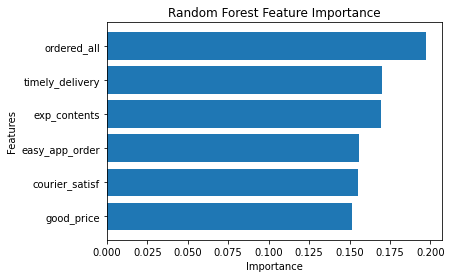

In [92]:
sorted_idx = rf_best_params.feature_importances_.argsort()                              # Sorting variables based on importance
plt.barh(X.columns[sorted_idx], rf_best_params.feature_importances_[sorted_idx])        # Plot bar graph for feature importance
plt.title('Random Forest Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

All features seem to be almost equally important based on Random Forest feature importance. Ordered_all, timely_delivery, exp_contents and easy_app_order are the 4 most important variables.

Moreover, Random forest feature importance has certain known drawbacks including its tendency to prefer variables with high cardinality (high number of possible values). Also, in the case of correlated variables, it selects one variable and ignores the other variables.

### 2. Permuation Importance - This method randomly shuffles features and computes change in model performance and is model agnostic. It also overcomes drawbacks of Random Forest feature importance.

Since this method is model agnostic, let's experiment with different models

### 2a. Logistic Regression

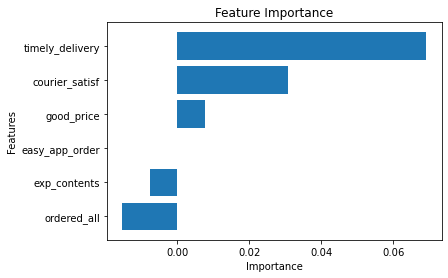

In [35]:
perm_importance = permutation_importance(logreg, X_test, y_test)                 # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

### 2b. K Nearest Neighbors

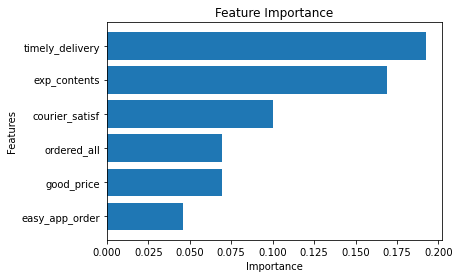

In [36]:
perm_importance = permutation_importance(knn_f, X_test, y_test)                  # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

### 2c. Decision Tree

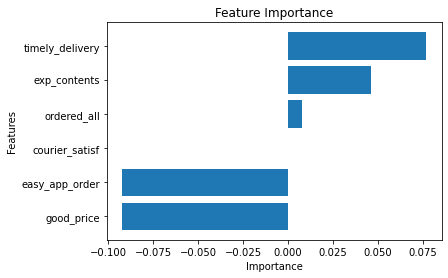

In [37]:
perm_importance = permutation_importance(dtc, X_test, y_test)                  # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

### 2d. Random Forest

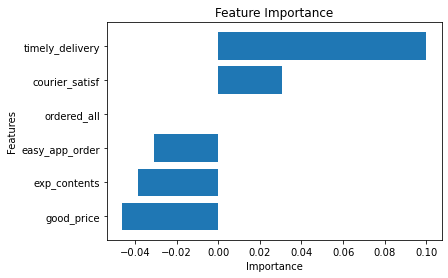

In [38]:
perm_importance = permutation_importance(rf, X_test, y_test)                  # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

### 2e. Gradient Boosting

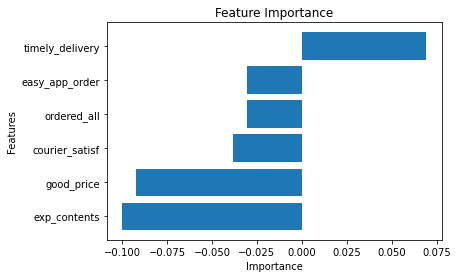

In [39]:
perm_importance = permutation_importance(gb, X_test, y_test)                  # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

Based on the above 5 plots, timey_delivery is clearly the most important variable. For other variables, all models give different results. Since KNN has the highest F1 score accuracy, we can go ahead with the results of KNN Permuation Feature importance.

The most important variables in order are timely_delivery, good_price, exp_contents and easy_app_order 

### Building KNN model with 4 important variables

In [40]:
X_new = X[['timely_delivery', 'good_price', 'exp_contents', 'easy_app_order']]

In [41]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size = 0.2, random_state = 0)
print(X_train_new.head())
print(X_train_new.shape)
print(X_test_new.shape)

     timely_delivery  good_price  exp_contents  easy_app_order
116                3           5             4               3
13                 4           5             2               3
33                 3           4             2               5
75                 3           3             2               4
26                 3           5             3               5
(100, 4)
(26, 4)


In [42]:
k_range = range(1,100)                                       # Range of k for experimentation
scores_new = {}                                              # Empty dictionary for storing scores for each value of k
score_list_new = []                                          # Empty list for storing scores
for k in k_range:                                            # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)              # Build an instance of KNeighborsClassifier Model
    knn.fit(X_train_new, y_train_new)                        # Fit the model with training data
    y_pred_knn = knn.predict(X_test_new)                     # Make predictions for test data
    scores_new[k] = f1_score(y_test_new, y_pred_knn)         # Generate F1 score and append to scores dictionary with respective k value
    score_list_new.append(f1_score(y_test_new, y_pred_knn))  # Append F1 score to score_list dictionary

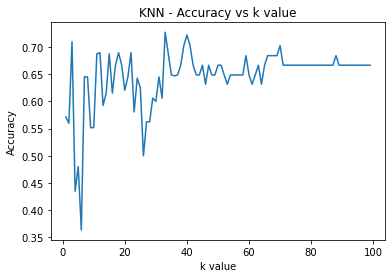

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_new)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [44]:
# Get maximum score
max(score_list_new)

0.7272727272727274

In [45]:
# Get K value for maximum score
max(scores_new, key=scores_new.get)

33

Maximum F1 score accuracy occurs at K = 33

### Final KNN Model

In [46]:
knn_f_new = KNeighborsClassifier(n_neighbors = 33)             # Build an instance of KNeighborsClassifier Model with k=10
knn_f_new.fit(X_train_new, y_train_new)                        # Fit the model with training data
y_pred_knn_f_new = knn_f_new.predict(X_test_new)               # Make predictions for test data

In [47]:
print(classification_report(y_test_new, y_pred_knn_f_new))

              precision    recall  f1-score   support

           0       0.83      0.38      0.53        13
           1       0.60      0.92      0.73        13

    accuracy                           0.65        26
   macro avg       0.72      0.65      0.63        26
weighted avg       0.72      0.65      0.63        26



Maximum KNN F1 score accuracy using only 4 important variables comes out to 65% when k = 33

Removing 2 least important features led to a 8% decrease in F1 score accuracy in the KNN model. Since it is a significant descrease in accuracy, it is in our best interest to use the KNN model with 6 important independent variables.

### 3. Shapley Additive Explanations (SHAP) - It is a novel approach which calculates feature importance on an observation level whereas sklearn computes global feature importance. The SHAP method is considered better than the sklearn methods because sklearn may not give most important features highest feature importance score.

In [48]:
xgb = XGBRegressor(n_estimators = 1000, max_depth = 10, learning_rate = 0.001)      # Create an instance of XGBRegressor
xgb.fit(X_train, y_train)                                                           # Fit model with training data
shap.initjs()                                                                       # Load JS visualization

In [49]:
explainer = shap.TreeExplainer(xgb)                             # Explain the model using shap
shap_values = explainer.shap_values(X_train)                    # Get shap values for training data

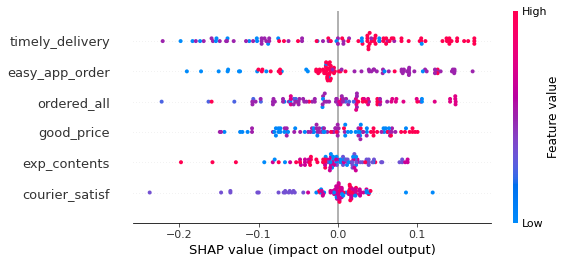

In [50]:
# Summary of feature importance for each observation 
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns)   

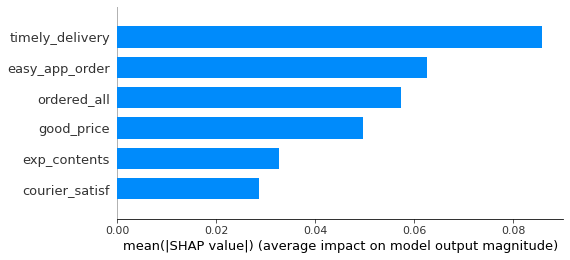

In [51]:
# Summary of feature importance for each observation using bar plot
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns, plot_type = 'bar')

Based on the above two plots, timely_delivery, easy_app_order, ordered_all and good_price are the most important variables using SHAP. This is contradicting to the 4 important variables (timely_delivery, exp_contents, courier_satisf and good_price) predicted by Permutation feature importance 

Lets build a KNN model with top 4 variables predicted by SHAP

In [52]:
X_shap = X[['timely_delivery','easy_app_order', 'ordered_all', 'good_price']]         # select 4 important variables in dataframe

In [53]:
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap, y, test_size = 0.2, random_state = 0)
print(X_train_shap.head())
print(X_train_shap.shape)
print(X_test_shap.shape)

     timely_delivery  easy_app_order  ordered_all  good_price
116                3               3            4           5
13                 4               3            4           5
33                 3               5            4           4
75                 3               4            3           3
26                 3               5            3           5
(100, 4)
(26, 4)


In [54]:
k_range = range(1,100)                                       # Range of k for experimentation
scores_new = {}                                              # Empty dictionary for storing scores for each value of k
score_list_new = []                                          # Empty list for storing scores
for k in k_range:                                            # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)              # Build an instance of KNeighborsClassifier Model
    knn.fit(X_train_shap, y_train_shap)                        # Fit the model with training data
    y_pred_knn = knn.predict(X_test_shap)                     # Make predictions for test data
    scores_new[k] = f1_score(y_test_shap, y_pred_knn)         # Generate F1 score and append to scores dictionary with respective k value
    score_list_new.append(f1_score(y_test_shap, y_pred_knn))  # Append F1 score to score_list dictionary

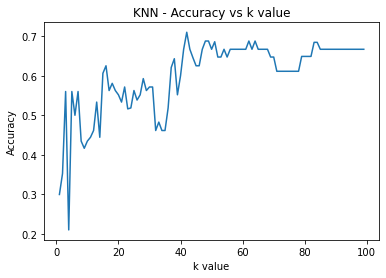

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_new)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [56]:
# Get maximum score
max(score_list_new)

0.7096774193548387

In [57]:
# Get K value for maximum score
max(scores_new, key=scores_new.get)

42

Removing 2 least important variables leads to a decrease in F1 score accuracy by at least 3%. Hence, it is in our best interest to keep all 6 variables.

# Recursive Feature Elimination (RFECV)

Recursive Feature Elimination is a popular technique to iterately remove less important variables and finally arrive at an optimal model with few important features

In [58]:
rfecv = RFECV(estimator = rf, step = 1, cv = StratifiedKFold(10), scoring = 'f1_macro')  # Creating an instance of RFECV usin Random Forest as estimator
rfecv.fit(X,y)                                                                           # Fitting data into rfecv

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=0), scoring='f1_macro')

In [59]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 4


Optimal number of features for RFECV with Random Forest as estimator is 4

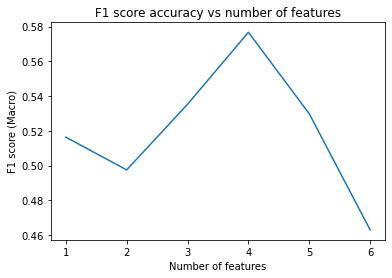

In [60]:
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.title("F1 score accuracy vs number of features")
plt.xlabel('Number of features')
plt.ylabel("F1 score (Macro)")
plt.show()

In [61]:
max(rfecv.grid_scores_)

0.5767478354978357

Maximum F1 score accuracy is 57.67% when number of features is 4

In [62]:
rfecv.estimator.feature_importances_

array([0.17070373, 0.16632131, 0.18128957, 0.14844633, 0.17471919,
       0.15851988])

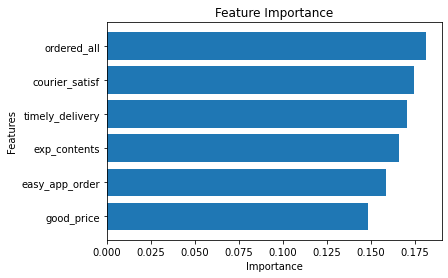

In [63]:
sorted_idx = rfecv.estimator.feature_importances_.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], rfecv.estimator.feature_importances_[sorted_idx])   # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

Ordered_all, courier_satif, timely_delivery, exp_contents are the 4 most important variables according to RFECV. This is the exact same result compared to Random Forest feature importance.

# Oversampling and Undersampling

There is a minor imbalance in our training dataset (1 - 56 datapoints, 0 - 44 datapoints). Let's try oversampling and undersampling techniques to balance our dataset and see whether it increases our F1 score accuracy.

In [64]:
# Current classfication distribution in training dataset
Counter(y_train)

Counter({1: 56, 0: 44})

Lets start with Oversampling first. We'll create synthetic observations only for the training dataset and not the test dataset. This will keep our test dataset pure and without synthetic samples.

In [65]:
ros = RandomOverSampler()                               # Create and instance of RandomOverSampler
X_ros, y_ros = ros.fit_resample(X_train, y_train)       # Resample training data
Counter(y_ros)                                          # Class distribution after oversampling

Counter({1: 56, 0: 56})

Both classes are now balanced as each class has 56 datapoints

### Building KNN model with oversampled training data

In [66]:
k_range = range(1,100)                                     # Range of k for experimentation
scores_os = {}                                             # Empty dictionary for storing scores for each value of k
score_list_os = []                                         # Empty list for storing scores
for k in k_range:                                          # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)            # Build an instance of KNeighborsClassifier Model
    knn.fit(X_ros, y_ros)                                  # Fit the model with training data
    y_pred_knn_os = knn.predict(X_test)                    # Make predictions for test data
    scores_os[k] = f1_score(y_test, y_pred_knn_os)         # Generate F1 score and append to scores dictionary with respective k value
    score_list_os.append(f1_score(y_test, y_pred_knn_os))  # Append F1 score to score_list_os dictionary

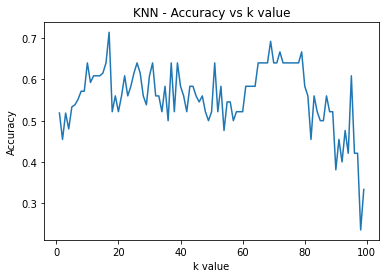

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_os)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [68]:
# Get maximum score
max(score_list_os)

0.7142857142857142

In [69]:
# Get K value for maximum score
max(scores_os, key=scores_os.get)

17

### Final Oversampled KNN model

In [70]:
knn_f_os = KNeighborsClassifier(n_neighbors = 67)                 # Build an instance of KNeighborsClassifier Model with k=10
knn_f_os.fit(X_ros, y_ros)                                    # Fit the model with training data
print(classification_report(y_test, knn_f_os.predict(X_test)))    # Generate classification report

              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.67      0.62      0.64        13

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.65      0.65      0.65        26



Oversampling keeps maximum F1 score accuracy to 73% which is same as accuracy without oversampling.

Let's now see whether undersampling increases accuracy.

In [71]:
rus = RandomUnderSampler()                               # Create and instance of RandomUnderSampler
X_rus, y_rus = rus.fit_resample(X_train, y_train)        # Resample training data
Counter(y_rus)                                           # Class distribution after undersampling

Counter({0: 44, 1: 44})

Both classes are now balanced as each class has 44 datapoints

### Building KNN model with undersampled training data

In [72]:
k_range = range(1,80)                                     # Range of k for experimentation
scores_us = {}                                             # Empty dictionary for storing scores for each value of k
score_list_us = []                                         # Empty list for storing scores
for k in k_range:                                          # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)            # Build an instance of KNeighborsClassifier Model
    knn.fit(X_rus, y_rus)                                  # Fit the model with training data
    y_pred_knn_us = knn.predict(X_test)                    # Make predictions for test data
    scores_us[k] = f1_score(y_test, y_pred_knn_us)         # Generate F1 score and append to scores dictionary with respective k value
    score_list_us.append(f1_score(y_test, y_pred_knn_us))  # Append F1 score to score_list_us dictionary

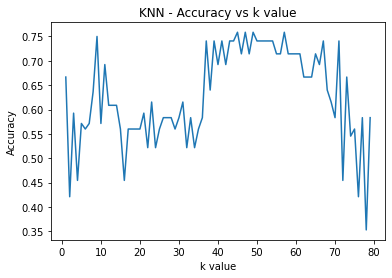

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_us)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [74]:
# Get maximum score
max(score_list_us)

0.7586206896551724

In [75]:
# Get K value for maximum score
max(scores_us, key=scores_us.get)

45

Maximum F1 score accuracy with undersampled model occurs at K = 67 and it hovers around low seventies.

### Building final KNN model with undersampled training data and K = 67

In [76]:
knn_f_us = KNeighborsClassifier(n_neighbors = 67)     # Build an instance of KNeighborsClassifier Model with k=10
knn_f_us.fit(X_rus, y_rus)                            # Fit the model with training data
y_pred_knn_f_us = knn_f_us.predict(X_test)            # Make predictions for test data

In [77]:
print(classification_report(y_test, y_pred_knn_f_us))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.71      0.77      0.74        13

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



Undersampling and oversampling does not affect the F1 score accuracy.

# Lazy Predict

LazyPredict is a Python library which analyzes a bunch of models with few lines of codes. Once we have a bunch of models and their F1 scores, we can run top 3 models and analyze the cross validation score.

Let's try lazypredict with 6 variables, 4 important variables selected using Permutation importance and 4 important variables selected using SHAP

### a. All 6 variables

In [78]:
lzy = LazyClassifier(predictions = True)                              # Create an instance of LazyClassifier
models, predictions = lzy.fit(X_train, X_test, y_train, y_test)       # Fit train and test data
models                                                                # Generate results for various models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 28.66it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.73,0.73,0.73,0.71,0.02
PassiveAggressiveClassifier,0.69,0.69,0.69,0.69,0.02
NearestCentroid,0.69,0.69,0.69,0.69,0.02
LGBMClassifier,0.65,0.65,0.65,0.65,0.05
BernoulliNB,0.62,0.62,0.62,0.61,0.01
SGDClassifier,0.62,0.62,0.62,0.62,0.01
GaussianNB,0.62,0.62,0.62,0.61,0.02
LogisticRegression,0.62,0.62,0.62,0.59,0.02
LinearDiscriminantAnalysis,0.58,0.58,0.58,0.54,0.02


Perceptron, PassiveAggressiveClassifer and NearestCentroid have the highest F1 score accuracy topping at 71%.

### b. 4 important variables selected using Permutation importance

In [79]:
lzy = LazyClassifier(predictions = True)                                              # Create an instance of LazyClassifier
models, predictions = lzy.fit(X_train_new, X_test_new, y_train_new, y_test_new)       # Fit train and test data
models                                                                                # Generate results for various models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.11it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.77,0.77,0.77,0.77,0.01
PassiveAggressiveClassifier,0.77,0.77,0.77,0.77,0.01
LGBMClassifier,0.73,0.73,0.73,0.73,0.05
BernoulliNB,0.73,0.73,0.73,0.73,0.01
Perceptron,0.73,0.73,0.73,0.73,0.01
NuSVC,0.69,0.69,0.69,0.68,0.02
SGDClassifier,0.65,0.65,0.65,0.63,0.01
LabelSpreading,0.65,0.65,0.65,0.65,0.01
CalibratedClassifierCV,0.62,0.62,0.62,0.55,0.04


NearestCentroid, PassiveAggressiveClassifer and LGBMCLassifier have the highest F1 score accuracy topping at 77% for NearestCenroid and PassivAggressiveClassifer which is notably highest F1 accuracy achieved till now.

### c. 4 important variables selected using SHAP

In [80]:
lzy = LazyClassifier(predictions = True)                                                  # Create an instance of LazyClassifier
models, predictions = lzy.fit(X_train_shap, X_test_shap, y_train_shap, y_test_shap)       # Fit train and test data
models    

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 27.51it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.73,0.73,0.73,0.73,0.02
PassiveAggressiveClassifier,0.65,0.65,0.65,0.65,0.02
NearestCentroid,0.65,0.65,0.65,0.65,0.02
LinearSVC,0.62,0.62,0.62,0.59,0.02
LabelPropagation,0.62,0.62,0.62,0.62,0.02
XGBClassifier,0.62,0.62,0.62,0.61,0.07
RidgeClassifier,0.62,0.62,0.62,0.59,0.02
LogisticRegression,0.62,0.62,0.62,0.59,0.02
LinearDiscriminantAnalysis,0.62,0.62,0.62,0.59,0.01


Highest F1 score accuracy tops at 73% for SGDC classifer

Now lets build the models for top 3 winning models predicted by Lazypredict using 4 important variables selected using Permutation importance as it promises up to 77% F1 score accuracy.

### 1. Nearest Centroid

In [81]:
nc = NearestCentroid()                                                 # Create an instance of NearestCentroid
nc.fit(X_train_new, y_train_new.values.ravel())                        # Fit model with training data
print(classification_report(y_test_new, nc.predict(X_test_new)))       # Generate classification report

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.77      0.77      0.77        13

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26



Maximum F1 score accuracy achived is 77% and it matches with Lazypredict's estimate.

In [82]:
cross_val_score(nc, X_train_new, y_train_new, cv=10)                  # Generate results for cross vaidation

array([0.7, 0.5, 0.6, 0.5, 0.7, 0.7, 0.5, 0.6, 0.5, 0.5])

Cross validation inddicates that F1 score accuracy needs to be in the range [0.5, 0.7] which matches our F1 score accuracy. 

### 2. Passive Aggressive Classifier

In [83]:
pac = PassiveAggressiveClassifier(C=0.5, random_state = 5)             # Create an instance of PassiveAggressiveClassifier
pac.fit(X_train_new, y_train_new)                                      # Fit model with training data

PassiveAggressiveClassifier(C=0.5, random_state=5)

In [84]:
pac_pred = pac.predict(X_test_new)                                 # Make predictions for test data
print(classification_report(y_test_new, pac_pred))                 # Generate classification report

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        13
           1       0.00      0.00      0.00        13

    accuracy                           0.50        26
   macro avg       0.25      0.50      0.33        26
weighted avg       0.25      0.50      0.33        26



F1 score accuracy achieved using PassiveAggressiveClassifier is shockingly only 50% compared to our expectations of 77% predicted by Lazypredict

In [85]:
cross_val_score(pac, X_train_new, y_train_new, cv=10)                  # Generate results for cross vaidation

array([0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.5])

Our 50% F1 score matches the range of cross validation of [0.5, 0.6]

### 3. LightGBM

In [86]:
# Convert dataset into GBM format
lgbm_train = lgb.Dataset(X_train_new, label = y_train_new)

In [87]:
#Specifying the parameter
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=10

In [88]:
lgb = lgb.train(params, lgbm_train, 100)                        # Train LightGBM model with 100 epochs
lgb_pred = lgb.predict(X_test_new)                              # Make predctions
lgb_pred                                      

array([0.46042255, 0.65371763, 0.47359534, 0.43348251, 0.59183792,
       0.47359534, 0.47359534, 0.70610591, 0.6490728 , 0.4290891 ,
       0.4290891 , 0.47359534, 0.46042255, 0.69926619, 0.59183792,
       0.59183792, 0.70610591, 0.47359534, 0.47359534, 0.6490728 ,
       0.70610591, 0.69683602, 0.4290891 , 0.70610591, 0.6490728 ,
       0.64310782])

In [89]:
lgb_pred = lgb_pred.round(0).astype(int)               # Convert predictions into binary classification by rounding off
lgb_pred

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1])

In [90]:
print(classification_report(y_test, lgb_pred))         # Generate classification report

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.71      0.77      0.74        13

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



The F1 score accuracy predicted by LGBM classifier is 73% which is same as Lazy Predict's LGMClassifier's F1 score accuracy.

LazyPredict is a good way to experiment with a bunch of models quickly and familaze oneself with lesser known models. Moreover, it helped us identify a model which increased our F1 score accuracy by 4% to a final F1 score accuracy of 77%.

# Summary

1. Highest F1 score accuracy of 77% is achieved using Nearest Centroid model with 4 important variables (timely_delivery, good_price, exp_contents, easy_app_order) selected using Permutation feature importance.

2. Undersampling and oversampling does not affect the F1 score accuracy as the dataset has insignificant imbalance.